In [2]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split
import torch
from ultralytics import YOLO
import re
import pytesseract
from pytesseract import Output

In [3]:
dataset_path = '/kaggle/input/car-plate-detection'

In [4]:
def find_number_in_string(filepath):
    num = re.search(r'(\d+)', filepath)
    
    if num:
        return int(num.group(0))
    else:
        return 0

In [5]:
labels_dict = {
    'img_path': [],
    'x_min': [],
    'x_max': [],
    'y_min': [],
    'y_max': [],
    'w': [],
    'h': [],
}

In [6]:
xml_files = glob(f"{dataset_path}/annotations/*.xml")
xml_files

['/kaggle/input/car-plate-detection/annotations/Cars339.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars13.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars74.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars16.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars291.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars236.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars429.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars132.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars251.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars51.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars165.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars313.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars240.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars201.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars412.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars227.xml',
 '/kaggle/in

In [7]:
for file in sorted(xml_files, key = find_number_in_string):
    info = xet.parse(file)
    root = info.getroot()
    obj = root.find('object')
    bbox = obj.find('bndbox')
    x_min = int(bbox.find('xmin').text)
    y_min = int(bbox.find('ymin').text)
    x_max = int(bbox.find('xmax').text)
    y_max = int(bbox.find('ymax').text)
    
#     print(x_min, y_min, x_max, y_max)
    
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
#     print(img_path)
    height, width, channel = cv2.imread(img_path).shape
#     print(height, width, channel)
    labels_dict['img_path'].append(img_path)
    labels_dict['x_min'].append(x_min)
    labels_dict['x_max'].append(x_max)
    labels_dict['y_min'].append(y_min)
    labels_dict['y_max'].append(y_max)
    labels_dict['h'].append(height)
    labels_dict['w'].append(width)
    
#     break

In [8]:
data_df = pd.DataFrame(labels_dict)
data_df

,img_path,x_min,x_max,y_min,y_max,w,h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [9]:
train, val = train_test_split(data_df, test_size=1/10, random_state=10)
train, test = train_test_split(data_df, test_size=1/9, random_state=10)
print(len(train), len(val), len(test))

384 44 49


In [10]:
def folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'car_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'car_license_plate_new', split_name, 'images')
    
    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)
    
    for _, row, in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path'])) 
        x_center = (row['x_min'] + row['x_max'])/2 /row['w']
        y_center = (row['y_min'] + row['y_max'])/2 /row['h']
        width = (row['x_max'] - row['x_min']) /row['w']
        height = (row['y_max'] - row['y_min']) /row['h']
        
        label_path = os.path.join(labels_path, f"{img_name}.txt")
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.04} {y_center:.04} {width:.04} {height:.04}")
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
        
    print(f"successfully created {labels_path} and {images_path}")

In [11]:
folder_in_yolo_format("train", train, )
folder_in_yolo_format("test", test)
folder_in_yolo_format("val", val)

successfully created datasets/car_license_plate_new/train/labels and datasets/car_license_plate_new/train/images
successfully created datasets/car_license_plate_new/test/labels and datasets/car_license_plate_new/test/images
successfully created datasets/car_license_plate_new/val/labels and datasets/car_license_plate_new/val/images


In [12]:
datasets_yaml = '''
path: car_license_plate_new
train: train/images
test: test/images
val: val/images

no_of_class: 1
names: ['license_plate']

'''

with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)
    

In [13]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 133MB/s]


In [14]:
model.train(
data = 'datasets.yaml',
batch = 16,
epochs = 100,
device='cuda',
imgsz = 320,
cache=True
)

Ultralytics YOLOv8.2.73 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 26.2MB/s]
2024-08-06 07:59:59,741	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-06 08:00:00,537	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/car_license_plate_new/train/labels... 384 images, 0 backgrounds, 0 corrupt: 100%|██████████| 384/384 [00:00<00:00, 481.68it/s]

train: New cache created: /kaggle/working/datasets/car_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 384/384 [00:01<00:00, 196.19it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/car_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 585.61it/s]


val: New cache created: /kaggle/working/datasets/car_license_plate_new/val/labels.cache


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 191.76it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.747G      1.746      2.912      1.305         27        320: 100%|██████████| 24/24 [00:04<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         44         44    0.00348      0.955      0.471      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.682G      1.504      1.489       1.16         36        320: 100%|██████████| 24/24 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]

                   all         44         44      0.986      0.114       0.47      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.696G       1.48      1.343      1.166         31        320: 100%|██████████| 24/24 [00:02<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


                   all         44         44      0.792      0.434      0.517      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      0.69G      1.569      1.301       1.23         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


                   all         44         44      0.693        0.5      0.557      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      0.69G      1.508      1.264      1.206         40        320: 100%|██████████| 24/24 [00:02<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


                   all         44         44       0.58        0.5      0.513      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      0.69G      1.476      1.151      1.137         35        320: 100%|██████████| 24/24 [00:02<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         44         44      0.663      0.591      0.693      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      0.69G      1.467        1.1      1.165         28        320: 100%|██████████| 24/24 [00:02<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         44         44      0.698      0.786      0.758      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      0.69G      1.437      1.068      1.155         31        320: 100%|██████████| 24/24 [00:02<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]

                   all         44         44      0.776      0.788      0.778      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.688G      1.456      1.048      1.141         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


                   all         44         44      0.827      0.795      0.805      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.688G      1.444      1.018      1.135         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44      0.889      0.732      0.812       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.688G      1.374     0.9409      1.112         34        320: 100%|██████████| 24/24 [00:02<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all         44         44      0.884      0.727      0.813      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.688G      1.346     0.9229      1.127         21        320: 100%|██████████| 24/24 [00:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


                   all         44         44      0.911      0.727      0.821      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.688G       1.32     0.8964      1.123         25        320: 100%|██████████| 24/24 [00:02<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         44         44      0.874       0.75      0.842      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.688G       1.33     0.9051      1.105         28        320: 100%|██████████| 24/24 [00:02<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         44         44      0.804      0.841      0.858      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.688G      1.314     0.8869      1.109         29        320: 100%|██████████| 24/24 [00:02<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         44         44      0.869      0.818      0.872        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.688G      1.296     0.8374      1.092         28        320: 100%|██████████| 24/24 [00:02<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         44         44      0.846      0.876      0.892      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      0.69G      1.286     0.8174      1.098         33        320: 100%|██████████| 24/24 [00:02<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         44         44      0.839      0.832      0.885      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.688G      1.265     0.8149      1.077         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         44         44      0.847      0.757      0.831      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.688G      1.227      0.817      1.064         23        320: 100%|██████████| 24/24 [00:02<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


                   all         44         44      0.947      0.818      0.856      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      0.69G      1.239     0.7729      1.059         26        320: 100%|██████████| 24/24 [00:02<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]

                   all         44         44      0.901      0.841      0.871       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.688G      1.275     0.8188       1.09         25        320: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


                   all         44         44      0.947      0.815      0.909      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.688G      1.182     0.7704      1.046         31        320: 100%|██████████| 24/24 [00:02<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         44         44       0.93      0.841        0.9      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      0.69G       1.22     0.7609      1.058         38        320: 100%|██████████| 24/24 [00:02<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]

                   all         44         44       0.94      0.818      0.908      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      0.69G      1.154      0.741      1.055         26        320: 100%|██████████| 24/24 [00:02<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         44         44      0.929      0.818      0.895      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.688G      1.182      0.746      1.031         35        320: 100%|██████████| 24/24 [00:02<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         44         44      0.894      0.818      0.872      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      0.69G      1.186     0.7521      1.067         36        320: 100%|██████████| 24/24 [00:02<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


                   all         44         44      0.895      0.795      0.877      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.688G      1.149     0.7116      1.034         33        320: 100%|██████████| 24/24 [00:02<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]


                   all         44         44      0.856      0.886      0.876      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      0.69G      1.137     0.7313      1.018         36        320: 100%|██████████| 24/24 [00:02<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.38it/s]

                   all         44         44      0.883      0.795      0.862      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.688G      1.119     0.7047      1.038         22        320: 100%|██████████| 24/24 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         44         44      0.915      0.818      0.898      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.688G      1.066     0.6705       1.02         27        320: 100%|██████████| 24/24 [00:02<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


                   all         44         44       0.92      0.864      0.898      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      0.69G      1.166     0.7078       1.04         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         44         44      0.898      0.796      0.864      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      0.69G      1.139     0.7058      1.035         33        320: 100%|██████████| 24/24 [00:02<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         44         44      0.972      0.773      0.914      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      0.69G      1.122     0.6711      1.011         28        320: 100%|██████████| 24/24 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.878      0.841       0.89      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.69G      1.123     0.6693      1.006         23        320: 100%|██████████| 24/24 [00:02<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44       0.86      0.838      0.896      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.69G      1.083     0.6538      1.016         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         44         44      0.902      0.835      0.898      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      0.69G      1.042     0.6554     0.9971         32        320: 100%|██████████| 24/24 [00:02<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]

                   all         44         44      0.902      0.864      0.898      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.688G      1.078     0.6541       1.02         28        320: 100%|██████████| 24/24 [00:02<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


                   all         44         44      0.917      0.841      0.888      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.688G      1.046     0.6483     0.9983         36        320: 100%|██████████| 24/24 [00:02<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


                   all         44         44      0.904      0.854      0.912      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      0.69G      1.047     0.6326      1.013         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]

                   all         44         44      0.825      0.886      0.901      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.688G      1.083     0.6382      1.015         35        320: 100%|██████████| 24/24 [00:02<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         44         44      0.919      0.841      0.888      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.688G      1.058     0.6268      1.002         35        320: 100%|██████████| 24/24 [00:02<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.23it/s]


                   all         44         44      0.949       0.84      0.924      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      0.69G      1.031     0.6221     0.9933         32        320: 100%|██████████| 24/24 [00:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         44         44      0.883      0.841      0.921      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.688G      1.037     0.6142      0.996         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]

                   all         44         44      0.909      0.906      0.905      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.688G      1.091     0.6252      1.011         36        320: 100%|██████████| 24/24 [00:02<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]

                   all         44         44      0.923      0.817      0.913      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.688G      1.075     0.6167     0.9963         38        320: 100%|██████████| 24/24 [00:02<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]

                   all         44         44      0.916      0.841      0.935       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      0.69G     0.9853      0.616     0.9792         25        320: 100%|██████████| 24/24 [00:02<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]

                   all         44         44      0.902      0.864      0.922      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.688G      1.005     0.6096     0.9677         34        320: 100%|██████████| 24/24 [00:02<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

                   all         44         44      0.918      0.886      0.927      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      0.69G     0.9722     0.5865     0.9709         33        320: 100%|██████████| 24/24 [00:02<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         44         44      0.922      0.886      0.926      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.688G     0.9825     0.5834      0.987         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


                   all         44         44      0.926      0.864      0.917      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.69G     0.9354     0.5713     0.9564         40        320: 100%|██████████| 24/24 [00:02<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]

                   all         44         44      0.869      0.908      0.907      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      0.69G      0.934     0.5684      0.948         22        320: 100%|██████████| 24/24 [00:02<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]

                   all         44         44      0.932      0.886       0.93       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      0.69G     0.9866     0.5734     0.9714         39        320: 100%|██████████| 24/24 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.99it/s]

                   all         44         44      0.943      0.864      0.919      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.688G     0.9789     0.5792     0.9617         34        320: 100%|██████████| 24/24 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

                   all         44         44      0.957      0.818       0.92      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.688G     0.9978     0.5693     0.9697         24        320: 100%|██████████| 24/24 [00:02<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         44         44      0.943      0.841      0.922      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.69G     0.9568     0.5662     0.9502         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


                   all         44         44      0.902      0.864      0.904      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.688G     0.9344     0.5651     0.9618         38        320: 100%|██████████| 24/24 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.926      0.856      0.929      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      0.69G     0.9442     0.5591      0.957         23        320: 100%|██████████| 24/24 [00:02<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.929      0.899      0.926      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.688G     0.9254     0.5534     0.9568         34        320: 100%|██████████| 24/24 [00:02<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

                   all         44         44      0.928       0.88      0.934      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      0.69G     0.9223     0.5439     0.9672         25        320: 100%|██████████| 24/24 [00:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         44         44      0.926      0.859      0.923      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      0.69G     0.8779     0.5282     0.9582         43        320: 100%|██████████| 24/24 [00:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]

                   all         44         44      0.974      0.836      0.908      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      0.69G     0.8902     0.5385     0.9473         42        320: 100%|██████████| 24/24 [00:02<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


                   all         44         44      0.946      0.864      0.924      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      0.69G     0.8888     0.5328     0.9409         25        320: 100%|██████████| 24/24 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.33it/s]

                   all         44         44      0.899      0.886      0.944      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.69G     0.8863     0.5274     0.9387         33        320: 100%|██████████| 24/24 [00:02<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         44         44      0.947      0.818      0.907      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.688G      0.889     0.5335     0.9487         26        320: 100%|██████████| 24/24 [00:02<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]

                   all         44         44      0.944      0.841       0.91      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.688G     0.9016     0.5292      0.949         28        320: 100%|██████████| 24/24 [00:02<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

                   all         44         44       0.92      0.864      0.929      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.69G     0.9423     0.5382     0.9638         35        320: 100%|██████████| 24/24 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         44         44      0.948      0.795      0.938      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      0.69G     0.8841     0.5156     0.9489         35        320: 100%|██████████| 24/24 [00:02<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.23it/s]


                   all         44         44       0.93      0.903      0.939       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.688G     0.9059     0.5145     0.9477         36        320: 100%|██████████| 24/24 [00:02<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]

                   all         44         44      0.897      0.886       0.94       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.688G     0.8789     0.5129     0.9421         28        320: 100%|██████████| 24/24 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]

                   all         44         44      0.926      0.854      0.936      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      0.69G     0.8734      0.506     0.9492         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.41it/s]

                   all         44         44      0.903      0.864      0.925      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      0.69G     0.8893     0.5057     0.9571         34        320: 100%|██████████| 24/24 [00:02<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         44         44      0.924      0.864       0.93      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      0.69G     0.8525     0.4983     0.9435         31        320: 100%|██████████| 24/24 [00:02<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]

                   all         44         44      0.928      0.883       0.93      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      0.69G      0.823     0.4935     0.9219         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.94it/s]

                   all         44         44      0.904      0.886      0.935      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.688G     0.8638     0.5102     0.9524         35        320: 100%|██████████| 24/24 [00:02<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         44         44       0.95      0.862      0.901      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.688G     0.8293     0.4826     0.9463         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

                   all         44         44      0.951      0.883      0.927       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.688G     0.8281     0.4912     0.9412         27        320: 100%|██████████| 24/24 [00:02<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]

                   all         44         44      0.906      0.881      0.905      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      0.69G     0.8122     0.4865     0.9339         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]

                   all         44         44      0.877      0.864      0.908       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.688G     0.8379     0.4841     0.9463         39        320: 100%|██████████| 24/24 [00:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.38it/s]

                   all         44         44      0.946      0.804      0.891      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.688G     0.8117      0.492     0.9282         39        320: 100%|██████████| 24/24 [00:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44      0.903      0.849      0.908      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      0.69G     0.8229     0.4791     0.9416         34        320: 100%|██████████| 24/24 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]

                   all         44         44      0.963      0.818      0.929      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.688G     0.8339     0.4963     0.9376         39        320: 100%|██████████| 24/24 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.59it/s]

                   all         44         44       0.87      0.886      0.931      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.69G      0.832     0.4816      0.934         40        320: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         44         44      0.924      0.864      0.944      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.69G     0.8235     0.4662     0.9323         24        320: 100%|██████████| 24/24 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.71it/s]

                   all         44         44      0.952      0.904      0.923      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      0.69G     0.8023     0.4681     0.9415         24        320: 100%|██████████| 24/24 [00:02<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44      0.951      0.909      0.933      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      0.69G     0.7846     0.4629     0.9162         28        320: 100%|██████████| 24/24 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]

                   all         44         44       0.95      0.886      0.934      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.688G      0.788     0.4546     0.9202         31        320: 100%|██████████| 24/24 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.96it/s]

                   all         44         44      0.951      0.885      0.943      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      0.69G     0.7692      0.456     0.9295         35        320: 100%|██████████| 24/24 [00:02<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         44         44      0.952      0.904      0.956      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      0.69G     0.7947     0.4716     0.9271         30        320: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.923      0.864      0.946      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.688G     0.7735     0.4679     0.9218         22        320: 100%|██████████| 24/24 [00:02<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

                   all         44         44       0.95      0.859       0.93      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.69G     0.7687     0.4603     0.9405         38        320: 100%|██████████| 24/24 [00:02<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]

                   all         44         44      0.944      0.841      0.944      0.546


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.686G      1.048     0.5555      1.036         16        320: 100%|██████████| 24/24 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


                   all         44         44      0.921      0.841      0.927      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.686G      1.011     0.5295      1.017         16        320: 100%|██████████| 24/24 [00:02<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44       0.92      0.864       0.92      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.686G      1.015     0.5315      1.025         16        320: 100%|██████████| 24/24 [00:02<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.881      0.886      0.933      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.686G     0.9893     0.5087      0.994         15        320: 100%|██████████| 24/24 [00:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

                   all         44         44      0.904      0.841      0.932       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.686G     0.9699     0.5157      0.974         16        320: 100%|██████████| 24/24 [00:02<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


                   all         44         44      0.888      0.901      0.935      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.686G      1.013     0.5119     0.9912         16        320: 100%|██████████| 24/24 [00:02<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all         44         44       0.84      0.932      0.934      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.686G     0.9691     0.5023     0.9789         15        320: 100%|██████████| 24/24 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]


                   all         44         44      0.851      0.932      0.933      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.686G     0.9721     0.4904     0.9878         16        320: 100%|██████████| 24/24 [00:02<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]

                   all         44         44      0.827      0.909      0.932      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.686G     0.9601     0.4963     0.9724         16        320: 100%|██████████| 24/24 [00:02<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


                   all         44         44       0.85      0.899      0.936      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.686G     0.9562     0.4888      0.981         16        320: 100%|██████████| 24/24 [00:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.94it/s]

                   all         44         44      0.849      0.891      0.935      0.527



100 epochs completed in 0.094 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


                   all         44         44      0.952      0.904      0.956      0.577
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▄▅▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇█████▇███▇▇▇████▇███
metrics/mAP50-95(B),▂▁▄▅▆▆▇▆▇▆▇▇▇▇▇▇▇█▇██▇███▇█▇▇▇▇▇▇██▇▇▇▇█
metrics/precision(B),▁▇▆▇▇▇▇▇███▇█▇█▇██████████████▇███████▇█
metrics/recall(B),█▁▃▆▅▅▇▅▆▆▆▆▆▆▇▇▆▆▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▆█▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▃▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799f3d2088e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [15]:
import torchvision

In [16]:
torch.__version__

'2.1.2'

In [17]:
torchvision.__version__

'0.16.2'

In [18]:
log_dir = max(glob('runs/detect/train*'), key=find_number_in_string)
log_dir

'runs/detect/train'

In [19]:
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.74600,2.91160,1.30520,0.00348,0.95455,0.47053,0.23120,1.2880,2.93430,1.0666,0.000460,0.000460,0.000460
1,2,1.50390,1.48930,1.16000,0.98604,0.11364,0.47013,0.26195,1.3876,2.75240,1.1390,0.000931,0.000931,0.000931
2,3,1.47960,1.34300,1.16590,0.79236,0.43370,0.51728,0.18634,1.7894,2.37180,1.3973,0.001392,0.001392,0.001392
3,4,1.56930,1.30100,1.22990,0.69252,0.50000,0.55677,0.24407,1.7198,2.13950,1.2351,0.001844,0.001844,0.001844
4,5,1.50760,1.26440,1.20550,0.57961,0.50000,0.51341,0.23576,1.5526,1.79980,1.2600,0.001921,0.001921,0.001921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.01290,0.51192,0.99119,0.84025,0.93182,0.93405,0.54103,1.4138,0.65459,1.1926,0.000119,0.000119,0.000119
96,97,0.96907,0.50225,0.97894,0.85073,0.93182,0.93318,0.53890,1.4314,0.65554,1.1967,0.000099,0.000099,0.000099
97,98,0.97213,0.49039,0.98775,0.82702,0.90909,0.93194,0.53731,1.4419,0.66871,1.2048,0.000079,0.000079,0.000079
98,99,0.96013,0.49626,0.97241,0.84966,0.89921,0.93600,0.53713,1.4206,0.65862,1.1989,0.000060,0.000060,0.000060


In [20]:
results.columns = results.columns.str.strip()

In [21]:
results.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

In [22]:
results.index = results.index+1

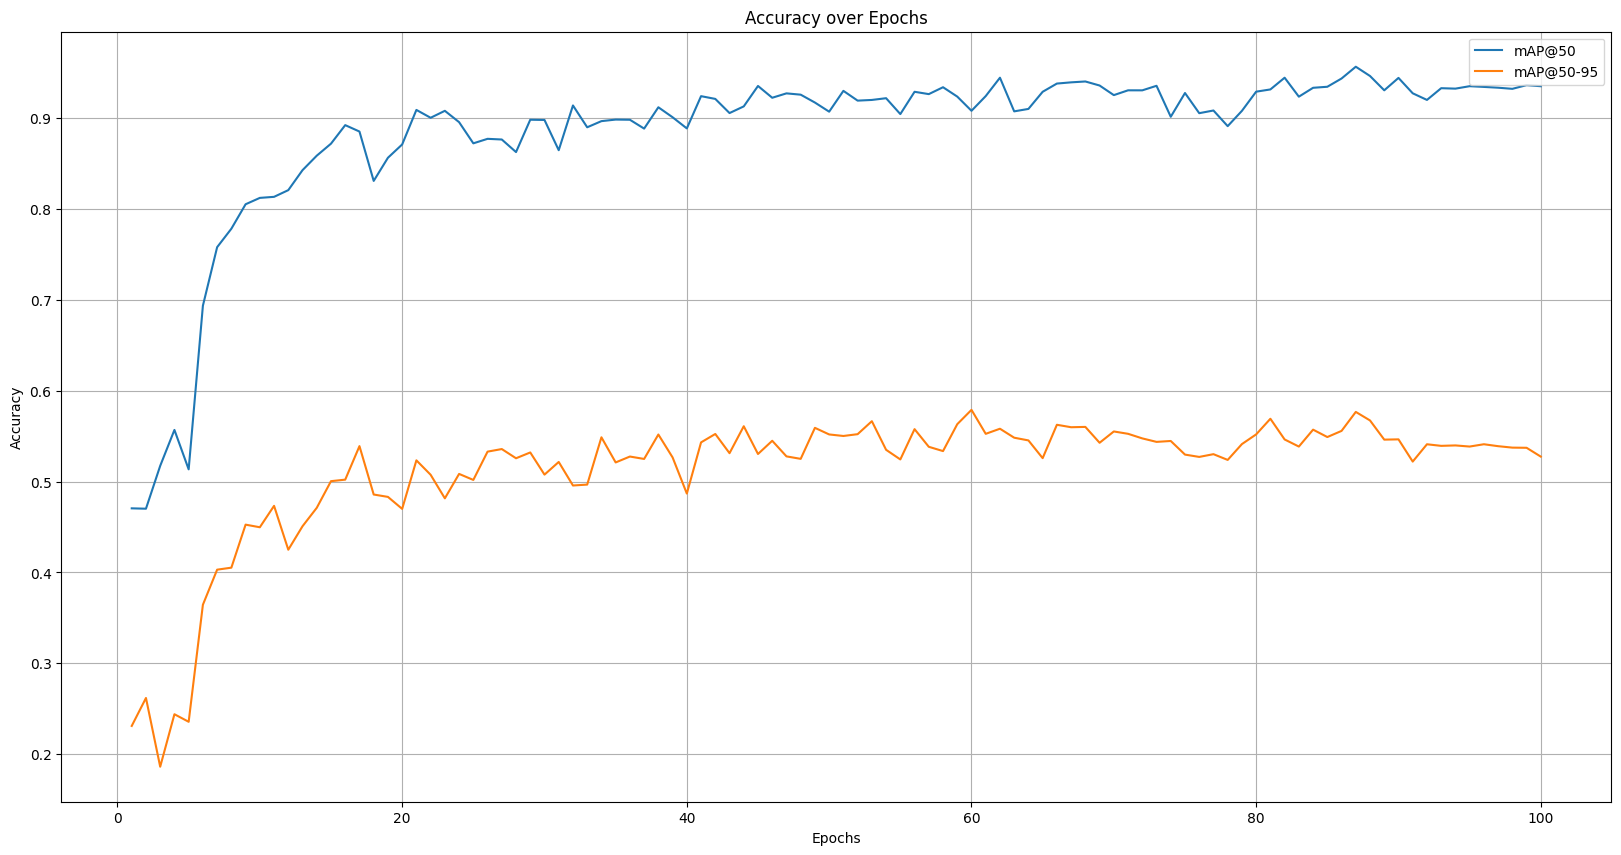

In [23]:
plt.figure(figsize = (20, 10))
plt.plot(results['metrics/mAP50(B)'], label='mAP@50')
plt.plot(results['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.legend()
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.show()

In [24]:
model.save('/kaggle/working/best_license_plate_model.pt')

In [25]:
def predict_the_plate(img_path):
    prediction = model.predict(img_path)
    img_arr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    for predict in prediction:
        for box in predict.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]
            
            roi = image_rgb[y1:y2, x1:x2]
            text = pytesseract.image_to_string(roi, config = '--psm 6')
            print(f"License plate number: {text}")
            
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image_rgb, f"confidence: {confidence * 100:.2f}%", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
            cv2.putText(image_rgb, f"License: {text}", (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

            
    plt.axis("off")
    plt.imshow(image_rgb)
    plt.show()


image 1/1 /kaggle/input/car-plate-detection/images/Cars100.png: 224x320 1 license_plate, 55.7ms
Speed: 0.8ms preprocess, 55.7ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
License plate number: AW 75550



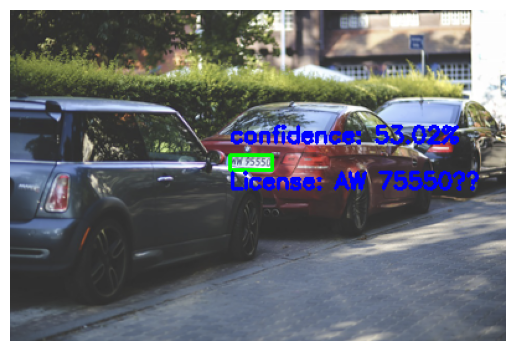

In [26]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars100.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars104.png: 256x320 1 license_plate, 55.2ms
Speed: 1.1ms preprocess, 55.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
License plate number: 


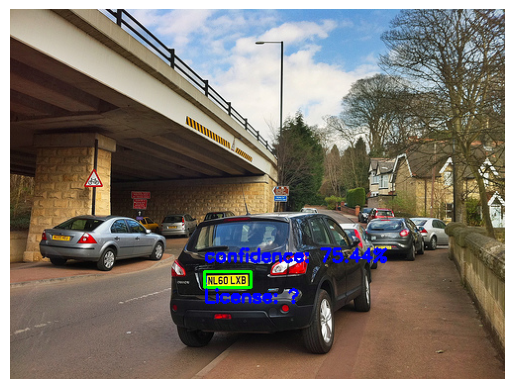

In [27]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars104.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars12.png: 128x320 1 license_plate, 51.1ms
Speed: 0.7ms preprocess, 51.1ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 320)
License plate number: =MH12BG7237



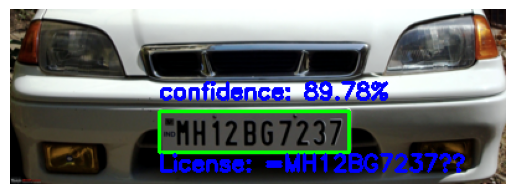

In [28]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars12.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars118.png: 224x320 1 license_plate, 8.2ms
Speed: 1.0ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
License plate number: JAG2 UAR



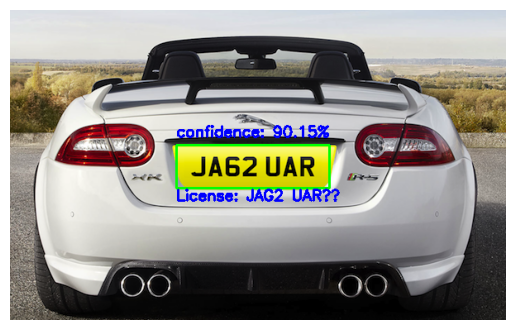

In [29]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars118.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars134.png: 224x320 1 license_plate, 7.5ms
Speed: 0.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
License plate number: USTLE



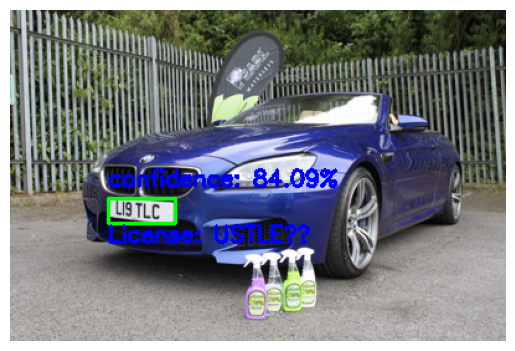

In [30]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars134.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars259.png: 192x320 1 license_plate, 50.1ms
Speed: 0.8ms preprocess, 50.1ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)
License plate number: /MH 20 EE 7598



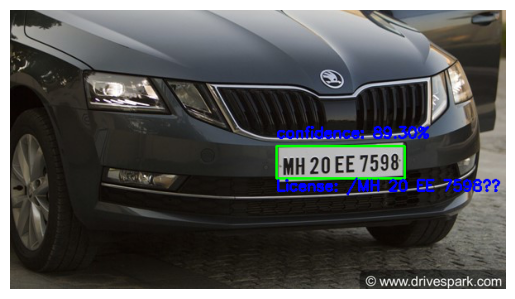

In [31]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars259.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars329.png: 224x320 1 license_plate, 8.2ms
Speed: 0.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
License plate number: | 16H



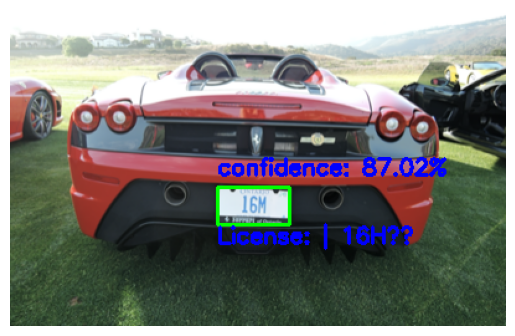

In [32]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars329.png")


image 1/1 /kaggle/input/car-plate-detection/images/Cars70.png: 192x320 1 license_plate, 8.2ms
Speed: 0.8ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 320)
License plate number: ae



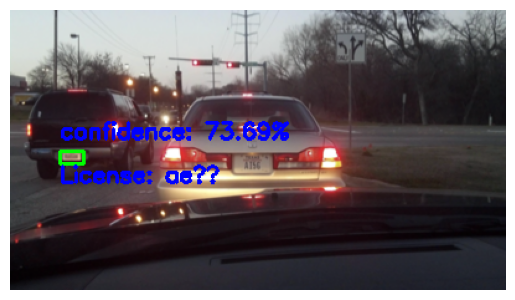

In [33]:
predict_the_plate("/kaggle/input/car-plate-detection/images/Cars70.png")